In [1]:
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping
from GameFormer.train_utils import *
from common_utils import *
from GameFormer.data_utils import *

data_path = '/data/fyy/GameFormer-Planner/nuplan/dataset/nuplan-v1.1/splits/mini'
map_path = '/data/fyy/GameFormer-Planner/nuplan/dataset/maps'
model_path = 'training_log/Exp_e40_dual/model_epoch_60_valADE_1.2866.pth'
map_version = "nuplan-maps-v1.0"
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False
sensor_root = None
db_files = None

scenario_mapping = ScenarioMapping(scenario_map=get_scenario_map(), subsample_ratio_override=0.5)
builder = NuPlanScenarioBuilder(data_path, map_path, sensor_root, db_files, map_version, scenario_mapping=scenario_mapping)

scenario_filter = ScenarioFilter(*get_filter_parameters(scenarios_per_type, total_scenarios, shuffle_scenarios))
worker = SingleMachineParallelExecutor(use_process_pool=True)
scenarios = builder.get_scenarios(scenario_filter, worker) 

In [189]:
idx = 4

In [190]:
from Planner.planner import Planner
from nuplan.planning.simulation.simulation import Simulation
from nuplan.planning.simulation.simulation_setup import SimulationSetup
import datetime
from nuplan.planning.simulation.callback.simulation_log_callback import SimulationLogCallback
from nuplan.planning.simulation.callback.metric_callback import MetricCallback
from nuplan.planning.simulation.callback.multi_callback import MultiCallback
from tqdm import tqdm
from nuplan.planning.simulation.controller.log_playback import LogPlaybackController
from nuplan.planning.simulation.controller.two_stage_controller import TwoStageController
from nuplan.planning.simulation.controller.tracker.lqr import LQRTracker
from nuplan.planning.simulation.controller.motion_model.kinematic_bicycle import KinematicBicycleModel
from nuplan.planning.simulation.observation.tracks_observation import TracksObservation
from nuplan.planning.simulation.observation.idm_agents import IDMAgents
from nuplan.planning.simulation.simulation_time_controller.step_simulation_time_controller import StepSimulationTimeController

experiment_name = 'open_loop_boxes'
job_name = 'gameformer_planner'
experiment_time = datetime.datetime.now()
experiment = f"{experiment_name}/{job_name}/{experiment_time}"  
output_dir = f"testing_log/{experiment}"
simulation_dir = "simulation"
metric_dir = "metrics"
aggregator_metric_dir = "aggregator_metric"
metric_engine = build_metrics_engine('open_loop_boxes', output_dir, metric_dir)
planner = Planner(model_path, 'cuda')

# Iterate through scenarios
# for scenario in tqdm(scenarios, desc='Running simulation'):

scenario = scenarios[idx]
tracker = LQRTracker(q_longitudinal=[10.0], r_longitudinal=[1.0], q_lateral=[1.0, 10.0, 0.0], 
                    r_lateral=[1.0], discretization_time=0.1, tracking_horizon=10, 
                    jerk_penalty=1e-4, curvature_rate_penalty=1e-2, 
                    stopping_proportional_gain=0.5, stopping_velocity=0.2)
motion_model = KinematicBicycleModel(get_pacifica_parameters())

# Ego Controller and Perception
if experiment == 'open_loop_boxes':
    ego_controller = LogPlaybackController(scenario) 
    observations = TracksObservation(scenario)
elif experiment == 'closed_loop_nonreactive_agents': 
    ego_controller = TwoStageController(scenario, tracker, motion_model)
    observations = TracksObservation(scenario)
else:      
    ego_controller = TwoStageController(scenario, tracker, motion_model)
    observations = IDMAgents(target_velocity=10, min_gap_to_lead_agent=1.0, headway_time=1.5,
                                accel_max=1.0, decel_max=2.0, scenario=scenario,
                                open_loop_detections_types=["PEDESTRIAN", "BARRIER", "CZONE_SIGN", 
                                                            "TRAFFIC_CONE", "GENERIC_OBJECT"])

# Simulation Manager
simulation_time_controller = StepSimulationTimeController(scenario)

# Stateful callbacks
metric_callback = MetricCallback(metric_engine=metric_engine)
sim_log_callback = SimulationLogCallback(output_dir, simulation_dir, "msgpack")

# Construct simulation and manager
simulation_setup = SimulationSetup(
    time_controller=simulation_time_controller,
    observations=observations,
    ego_controller=ego_controller,
    scenario=scenario,
)

simulation = Simulation(
    simulation_setup=simulation_setup,
    callback=MultiCallback([metric_callback, sim_log_callback])
)

simulation.callback.on_simulation_start(simulation.setup)

simulation.callback.on_initialization_start(simulation.setup, planner)

# Initialize Planner
planner.initialize(simulation.initialize())

# Execute specific callback
simulation.callback.on_initialization_end(simulation.setup, planner)

while simulation.is_simulation_running():
    simulation.callback.on_step_start(simulation.setup, planner)
    planner_input = simulation.get_planner_input()
    simulation.callback.on_planner_start(simulation.setup, planner)
    break


In [191]:
from Planner.planner_utils import *
from Planner.observation import *

# trajectory = planner.compute_trajectory(planner_input)
current_input = planner_input
history = current_input.history
traffic_light_data = list(current_input.traffic_light_data)
ego_state, observation = history.current_state

features = observation_adapter(history, traffic_light_data, planner._map_api, planner._route_roadblock_ids, planner._device)
trajectory = planner._plan(ego_state, history, traffic_light_data, observation)
reference_path = planner._get_reference_path(ego_state, traffic_light_data, observation)
with torch.no_grad():
    plan_init, predictions, scores, ego_state_transformed, neighbors_state_transformed = planner._get_prediction(features)
    plan = planner._trajectory_planner.plan(ego_state, ego_state_transformed, neighbors_state_transformed, predictions, plan_init, scores, reference_path, observation)

/data/fyy/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
/data/fyy/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
/data/fyy/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a fut

专家轨迹

In [192]:
ep = scenario.get_expert_ego_trajectory()
ep_list = list(scenario.get_expert_ego_trajectory())
ego_list = trajectory.get_sampled_trajectory()    # [0].waypoint.x

In [193]:
import pandas as pd

def create_dataframe_from_state_list(state_list):
    data_list = []
    for ego_traj in state_list:
        x = ego_traj.waypoint.x
        y = ego_traj.waypoint.y
        heading = ego_traj.waypoint.heading
        time_point = ego_traj.time_point
        velocity = ego_traj.waypoint.velocity
        velocity_x = velocity.x
        velocity_y = velocity.y
        data_list.append([x, y, heading, velocity_x, velocity_y, time_point])
        
    state_df = pd.DataFrame(data_list, columns=['x', 'y', 'heading', 'velocity_x', 'velocity_y', 'time_point'])

    return state_df

ego_df = create_dataframe_from_state_list(ego_list)
ep_df = create_dataframe_from_state_list(ep_list)

In [200]:
def plot_ego_and_expert_traj(ego_data, ep_data, y_label):
    plt.figure(figsize=(10, 5))
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
    x = np.linspace(0, 8, 80)
    plt.plot(x, ego_data[:80], label='规划轨迹')
    plt.plot(x, ep_data[:80], label='专家轨迹')
    plt.legend(fontsize=18)
    plt.xlabel('时间 (秒)', fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f'fig/expert/expert_idx={idx}_{y_label[:3]}')
    
def plot_ego_and_expert_velocity(ego_data, ep_data, y_label):
    plt.figure(figsize=(10, 5))
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
    x = np.linspace(0, 8, 80)
    plt.plot(x, ego_data[:80], label='规划轨迹')
    plt.plot(x, ep_data[:80], label='专家轨迹')
    plt.legend(fontsize=18)
    plt.xlabel('时间 (秒)', fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(-9, 9)
    plt.savefig(f'fig/expert/expert_idx={idx}_{y_label[:4]}')
    
def plot_ego_and_expert_heading(ego_data, ep_data, y_label):
    plt.figure(figsize=(10, 5))
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
    x = np.linspace(0, 8, 80)
    plt.plot(x, ego_data[:80], label='规划轨迹')
    plt.plot(x, ep_data[:80], label='专家轨迹')
    plt.legend(fontsize=18)
    plt.xlabel('时间 (秒)', fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(-3, 3)
    plt.savefig(f'fig/expert/expert_idx={idx}_{y_label[:4]}')

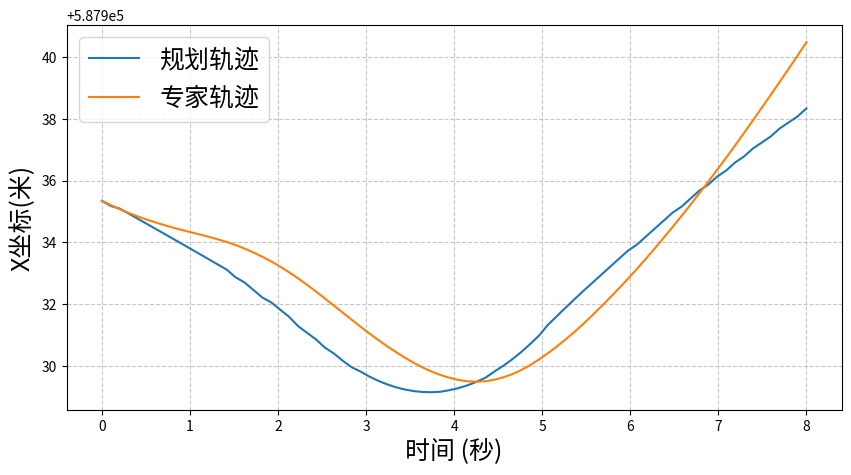

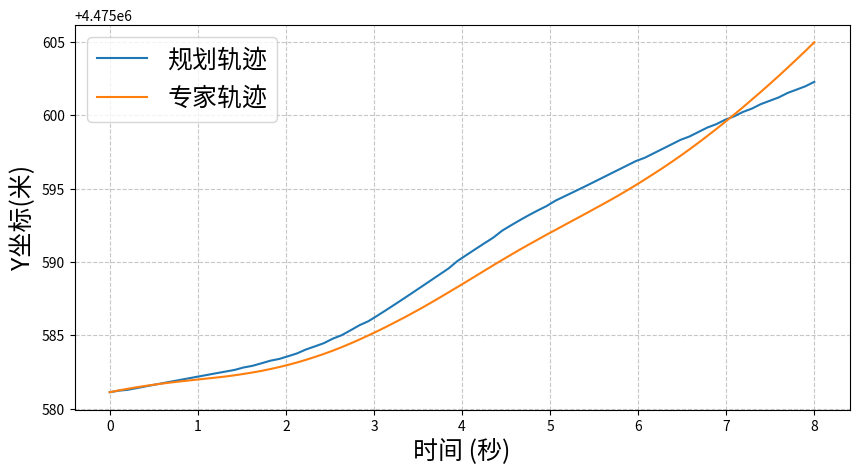

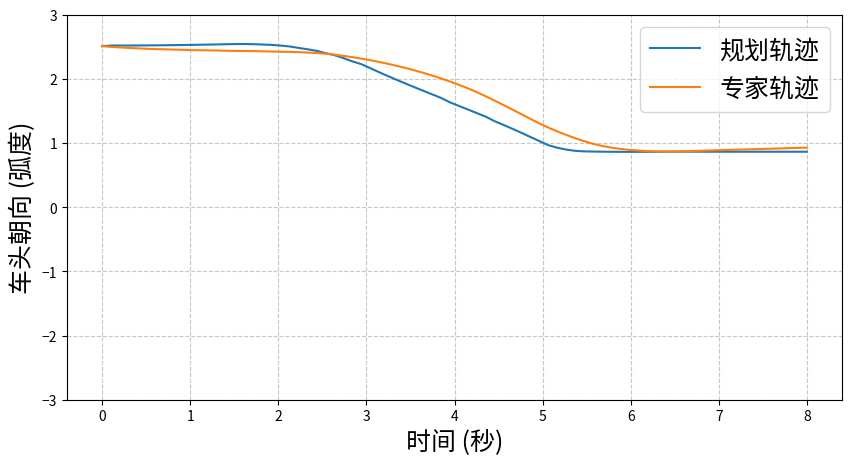

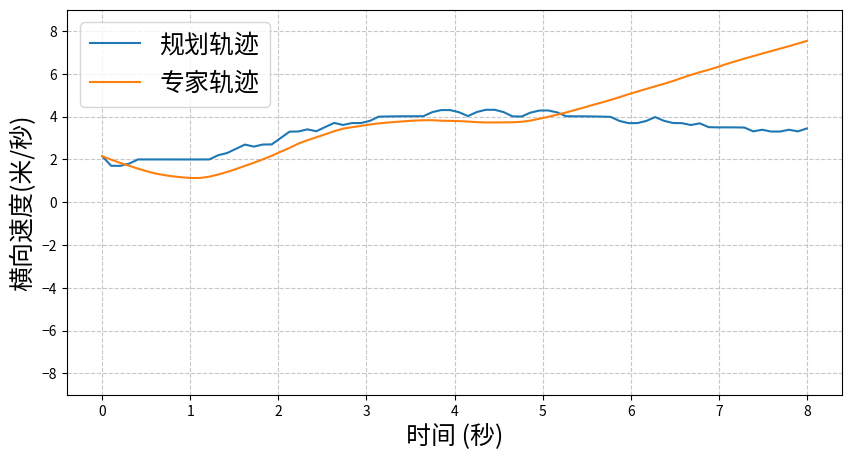

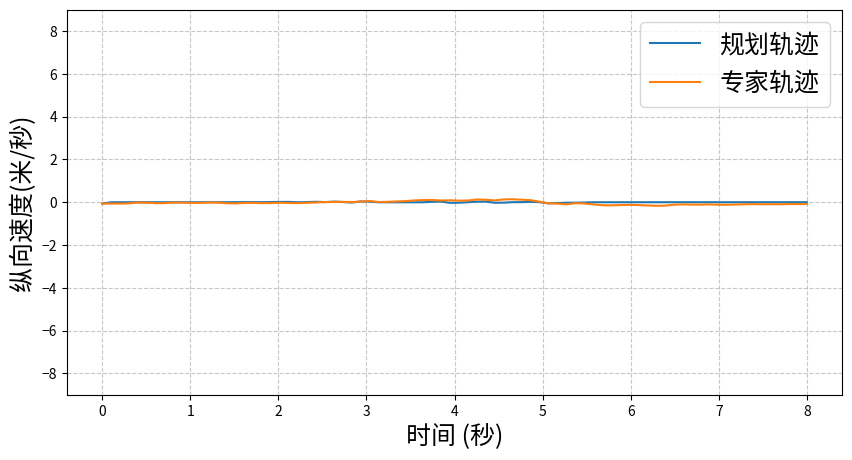

In [201]:
plot_ego_and_expert_traj(ego_df['x'], ep_df['x'], 'X坐标(米)')
plot_ego_and_expert_traj(ego_df['y'], ep_df['y'], 'Y坐标(米)')
plot_ego_and_expert_heading(ego_df['heading'], ep_df['heading'], '车头朝向 (弧度)')
plot_ego_and_expert_velocity(ego_df['velocity_x'], ep_df['velocity_x'], '横向速度(米/秒)')
plot_ego_and_expert_velocity(ego_df['velocity_y'], ep_df['velocity_y'], '纵向速度(米/秒)')